In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import BaseEstimator, ClassifierMixin
import math
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score)
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

*Briefly look at dataset and its shape, there are no string-columns*

In [4]:
data = pd.read_csv('train.csv')
data.head()

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  
3        1             0     0            2  
4        1             1     0            1  

[5 rows x 21 columns]

In [5]:
data.shape

(2000, 21)

*All cells are not empty - we do not have to fill them with some values*

In [6]:
print(data.info())

print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

*In case we need to replace nans - function provided below*

In [7]:
def replace_nan(df, column, classified_column = False, random_state = 42, **type):
    np.random.seed(random_state)
    
    mean_value = df[column].mean()
    std_value = df[column].std()
    max_value = df[column].max()
    nan_indices = df[df[column].isnull()].index
    if classified_column:
        random_values = np.random.randint(low=0, high=int(max_value), size=len(nan_indices))
    else:
        if type == 'float':
            random_values = np.random.uniform(low=0, high=mean_value + 3 * std_value, size=len(nan_indices))
        else:
            random_values = np.random.randint(low=0, high=int(mean_value + 3 * std_value), size=len(nan_indices))
    
    df.loc[nan_indices, column] = random_values

*Drop non-informative columns*

In [8]:
#data = data.drop(['car_ID', 'CarName'], axis = 1)

*With LabelEncoder we transfrom string-values to numbers (from 0 to n-1 where n number of different outputs)*

In [9]:
#data[['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 
#      'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']] = data[['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 
#      'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']].apply(LabelEncoder().fit_transform)

*Successfully transformed*

In [10]:
data

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842     0          2.2         0   1       0           7   
1              1021     1          0.5         1   0       1          53   
2               563     1          0.5         1   2       1          41   
3               615     1          2.5         0   0       0          10   
4              1821     1          1.2         0  13       1          44   
...             ...   ...          ...       ...  ..     ...         ...   
1995            794     1          0.5         1   0       1           2   
1996           1965     1          2.6         1   0       0          39   
1997           1911     0          0.9         1   1       1          36   
1998           1512     0          0.9         0   4       1          46   
1999            510     1          2.0         1   5       1          45   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
0       0.6        188        2  ...         20       756  2549     9     7   
1       0.7        136        3  ...        905      1988  2631    17     3   
2       0.9        145        5  ...       1263      1716  2603    11     2   
3       0.8        131        6  ...       1216      1786  2769    16     8   
4       0.6        141        2  ...       1208      1212  1411     8     2   
...     ...        ...      ...  ...        ...       ...   ...   ...   ...   
1995    0.8        106        6  ...       1222      1890   668    13     4   
1996    0.2        187        4  ...        915      1965  2032    11    10   
1997    0.7        108        8  ...        868      1632  3057     9     1   
1998    0.1        145        5  ...        336       670   869    18    10   
1999    0.9        168        6  ...        483       754  3919    19     4   

      talk_time  three_g  touch_screen  wifi  price_range  
0            19        0             0     1            1  
1             7        1             1     0            2  
2             9        1             1     0            2  
3            11        1             0     0            2  
4            15        1             1     0            1  
...         ...      ...           ...   ...          ...  
1995         19        1             1     0            0  
1996         16        1             1     1            2  
1997          5        1             1     0            3  
1998         19        1             1     1            0  
1999          2        1             1     1            3  

[2000 rows x 21 columns]

In [11]:
data.describe()

battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min       0.000000     2.000000     0.100000    80.000000     1.000000  ...   
25%       0.000000    16.000000     0.200000   109.000000     3.000000  ...   
50%       1.000000    32.000000     0.500000   141.000000     4.000000  ...   
75%       1.000000    48.000000     0.800000   170.000000     7.000000  ...   
max       1.000000    64.000000     1.000000   200.000000     8.000000  ...   

         px_height     px_width          ram         sc_h         sc_w  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean    645.108000  1251.515500  2124.213000    12.306500     5.767000   
std     443.780811   432.199447  1084.732044     4.213245     4.356398   
min       0.000000   500.000000   256.000000     5.000000     0.000000   
25%     282.750000   874.750000  1207.500000     9.000000     2.000000   
50%     564.000000  1247.000000  2146.500000    12.000000     5.000000   
75%     947.250000  1633.000000  3064.500000    16.000000     9.000000   
max    1960.000000  1998.000000  3998.000000    19.000000    18.000000   

         talk_time      three_g  touch_screen         wifi  price_range  
count  2000.000000  2000.000000   2000.000000  2000.000000  2000.000000  
mean     11.011000     0.761500      0.503000     0.507000     1.500000  
std       5.463955     0.426273      0.500116     0.500076     1.118314  
min       2.000000     0.000000      0.000000     0.000000     0.000000  
25%       6.000000     1.000000      0.000000     0.000000     0.750000  
50%      11.000000     1.000000      1.000000     1.000000     1.500000  
75%      16.000000     1.000000      1.000000     1.000000     2.250000  
max      20.000000     1.000000      1.000000     1.000000     3.000000  

[8 rows x 21 columns]

*Plot correlation matrix*

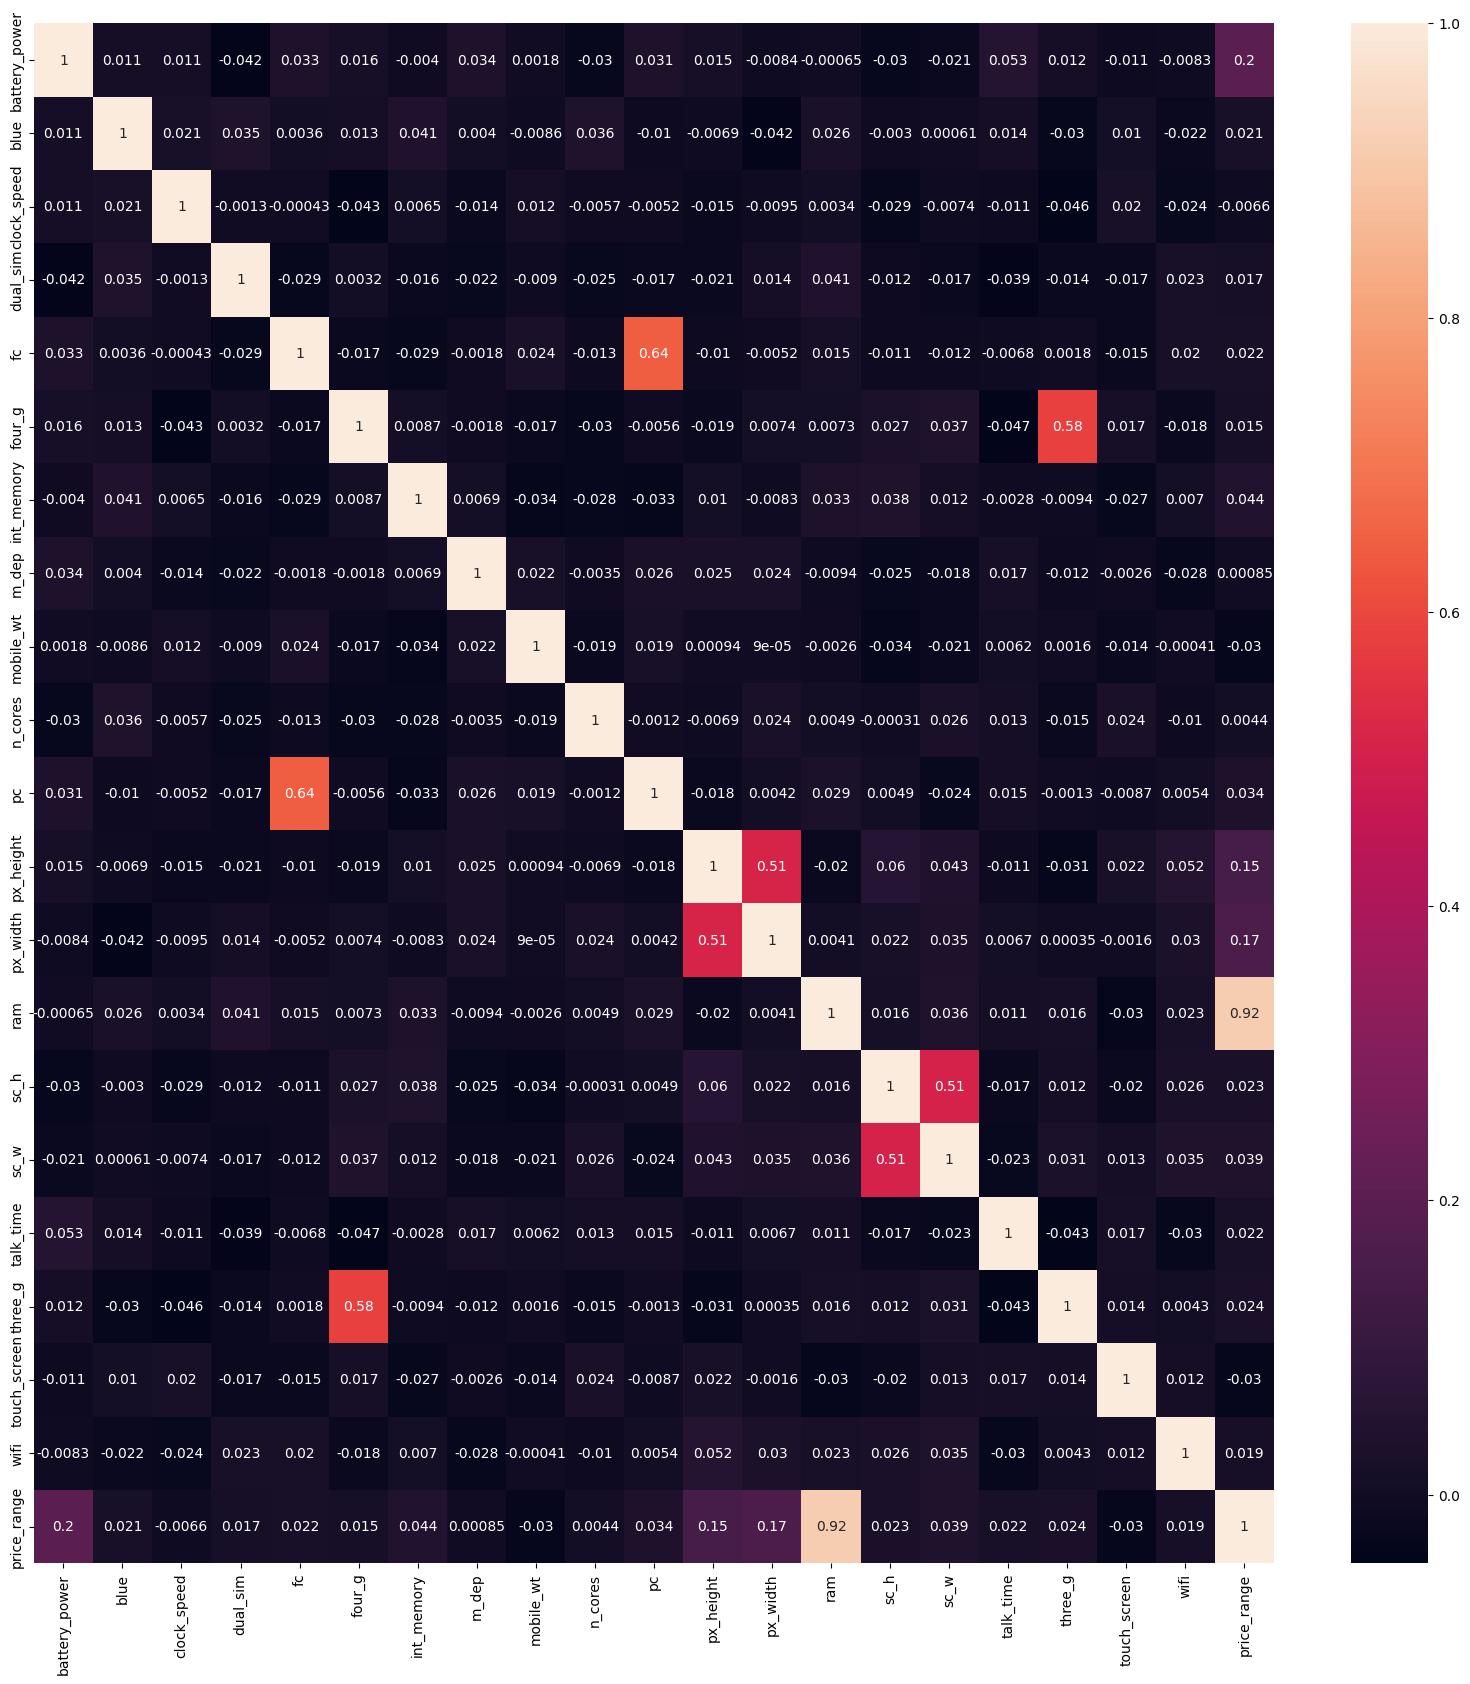

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True)
plt.show()

*Correlation between features and targer_value - price (sorted by descending)*

In [13]:
corr_matrix = data.corr()
corr_matrix["price_range"].sort_values(ascending = False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

*Plot the pairplot - scatter and bar plots (only for half of features due to large number of them present in dataset (i chose with good correlation and mostly initially not-string )) for feature vs feature and feature vs target value*

<Figure size 4000x4000 with 0 Axes>

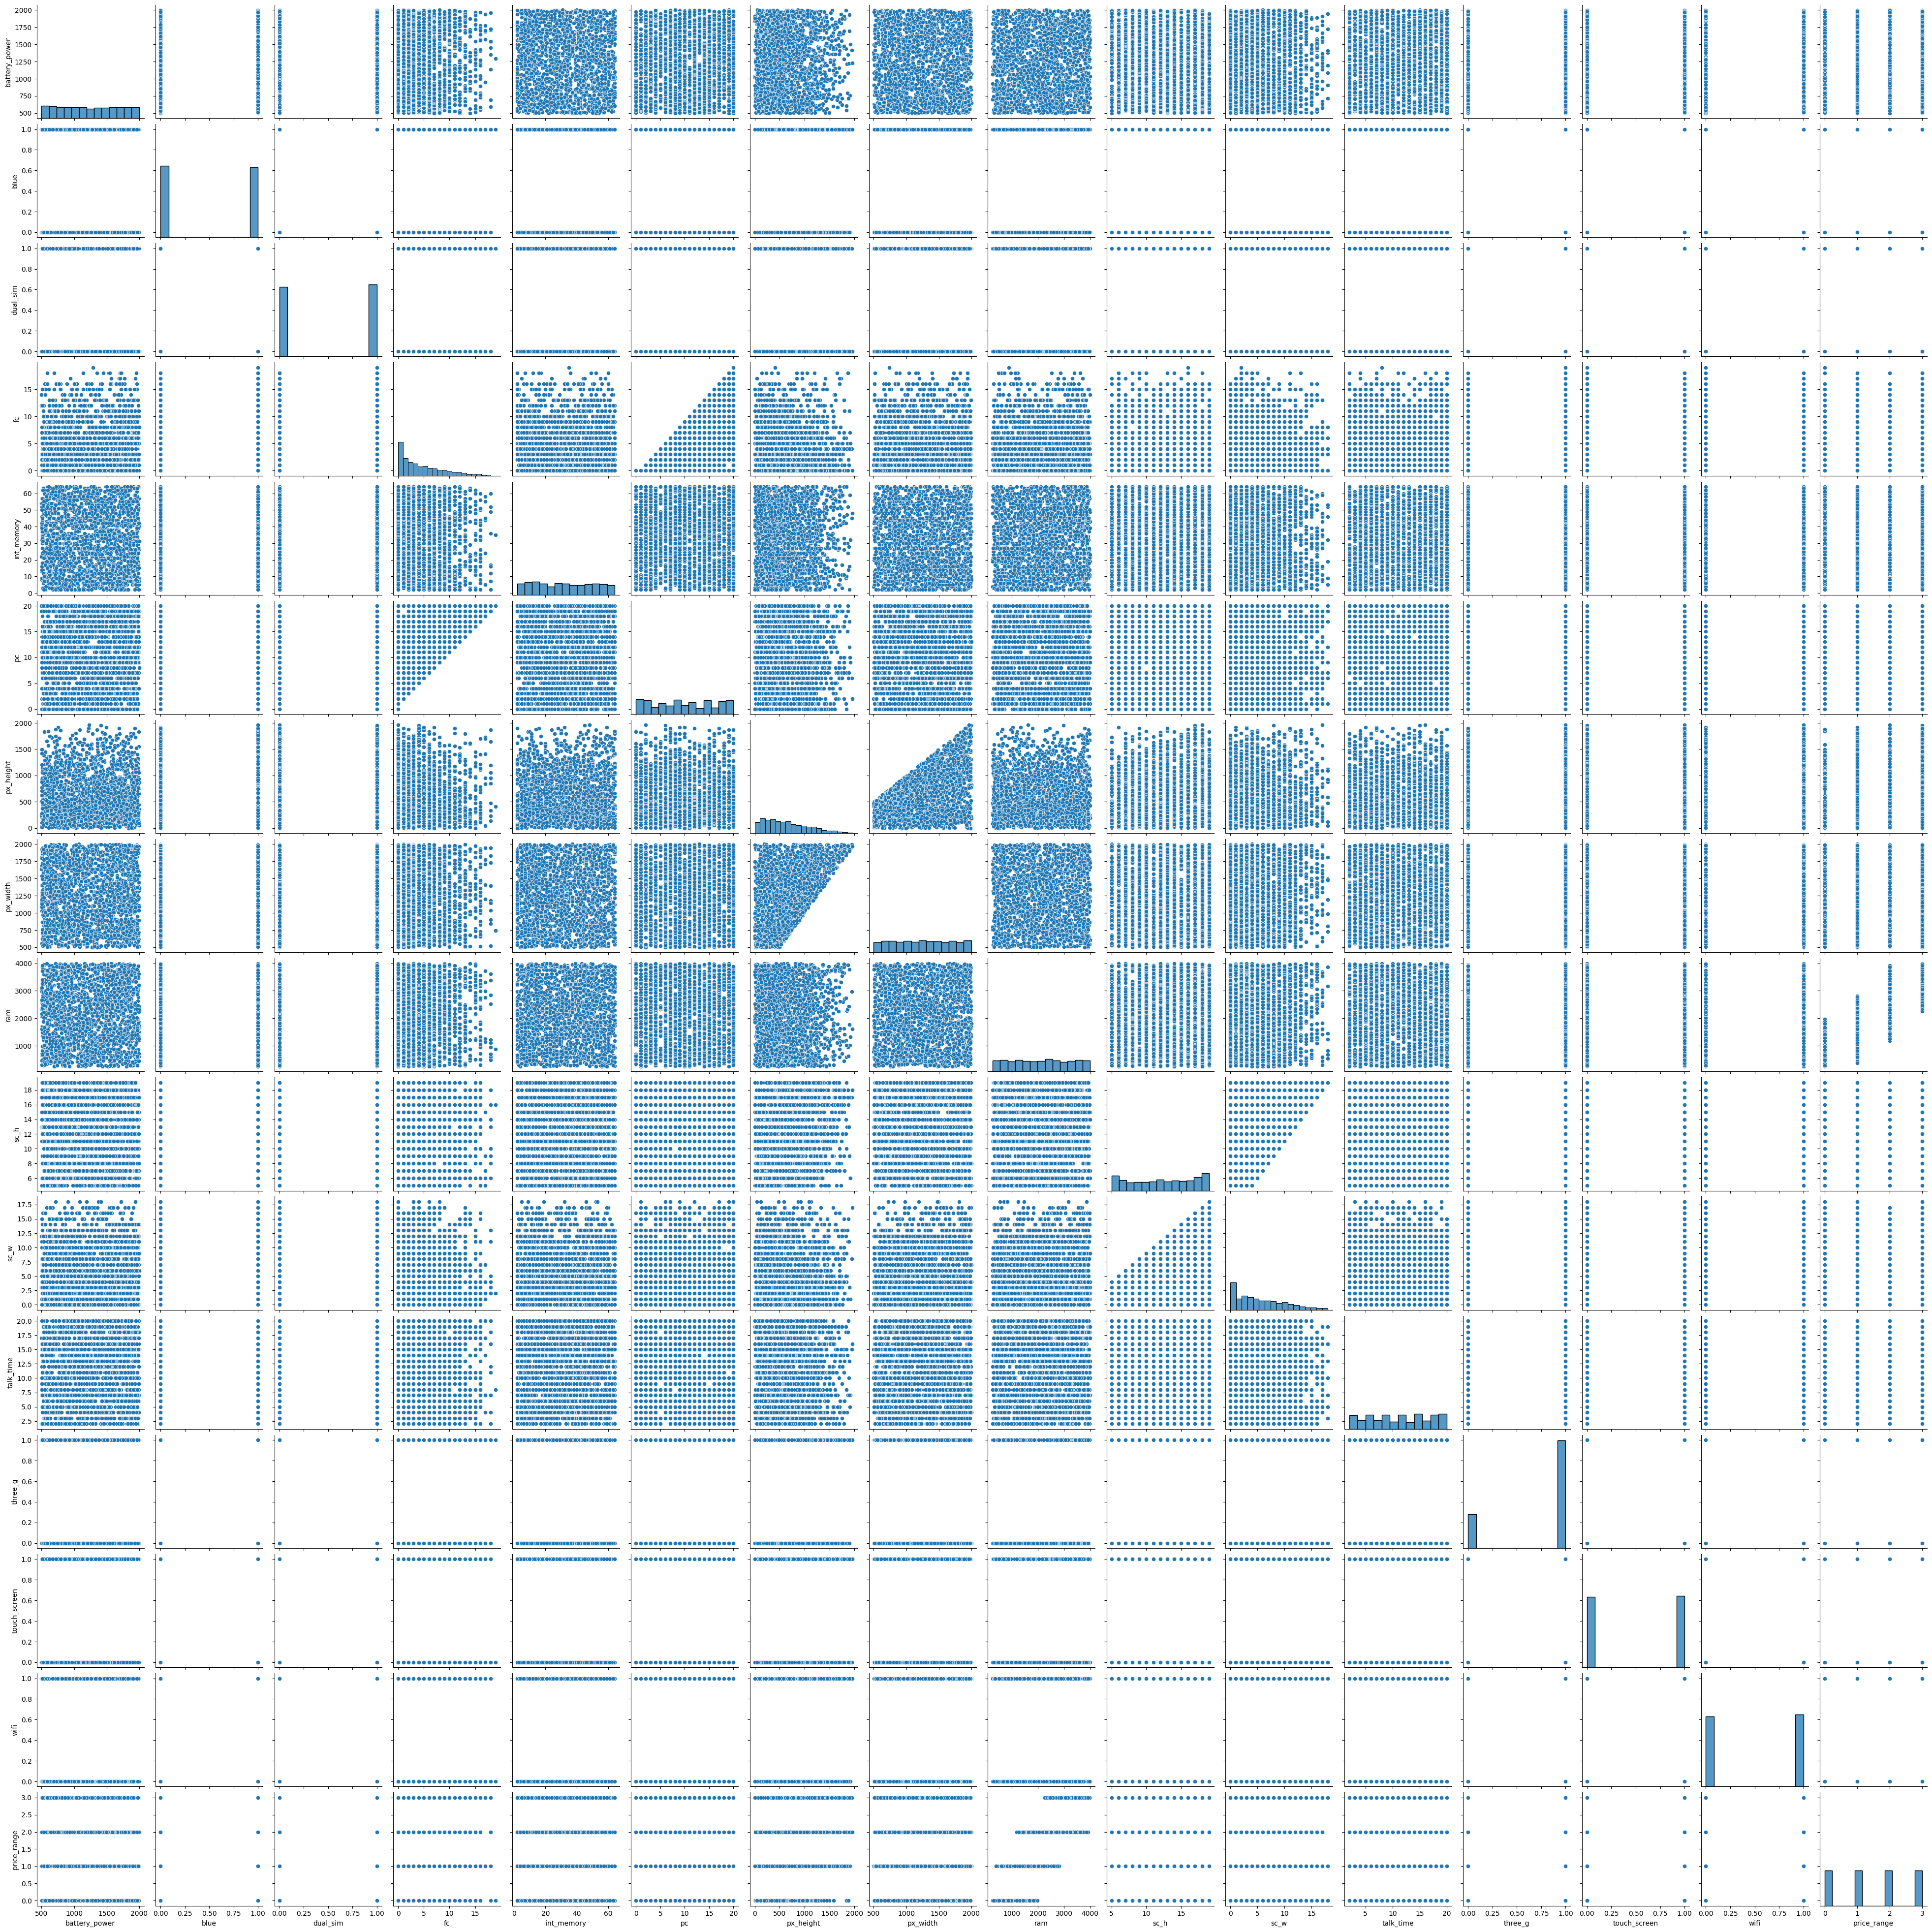

In [14]:
plt.figure(figsize=(40,40))
sns.pairplot(data[['battery_power',
 'blue',
 'dual_sim',
 'fc',
 'int_memory',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'three_g',
 'touch_screen',
 'wifi',
 'price_range']])
plt.show()

*Plot bar charts for features*

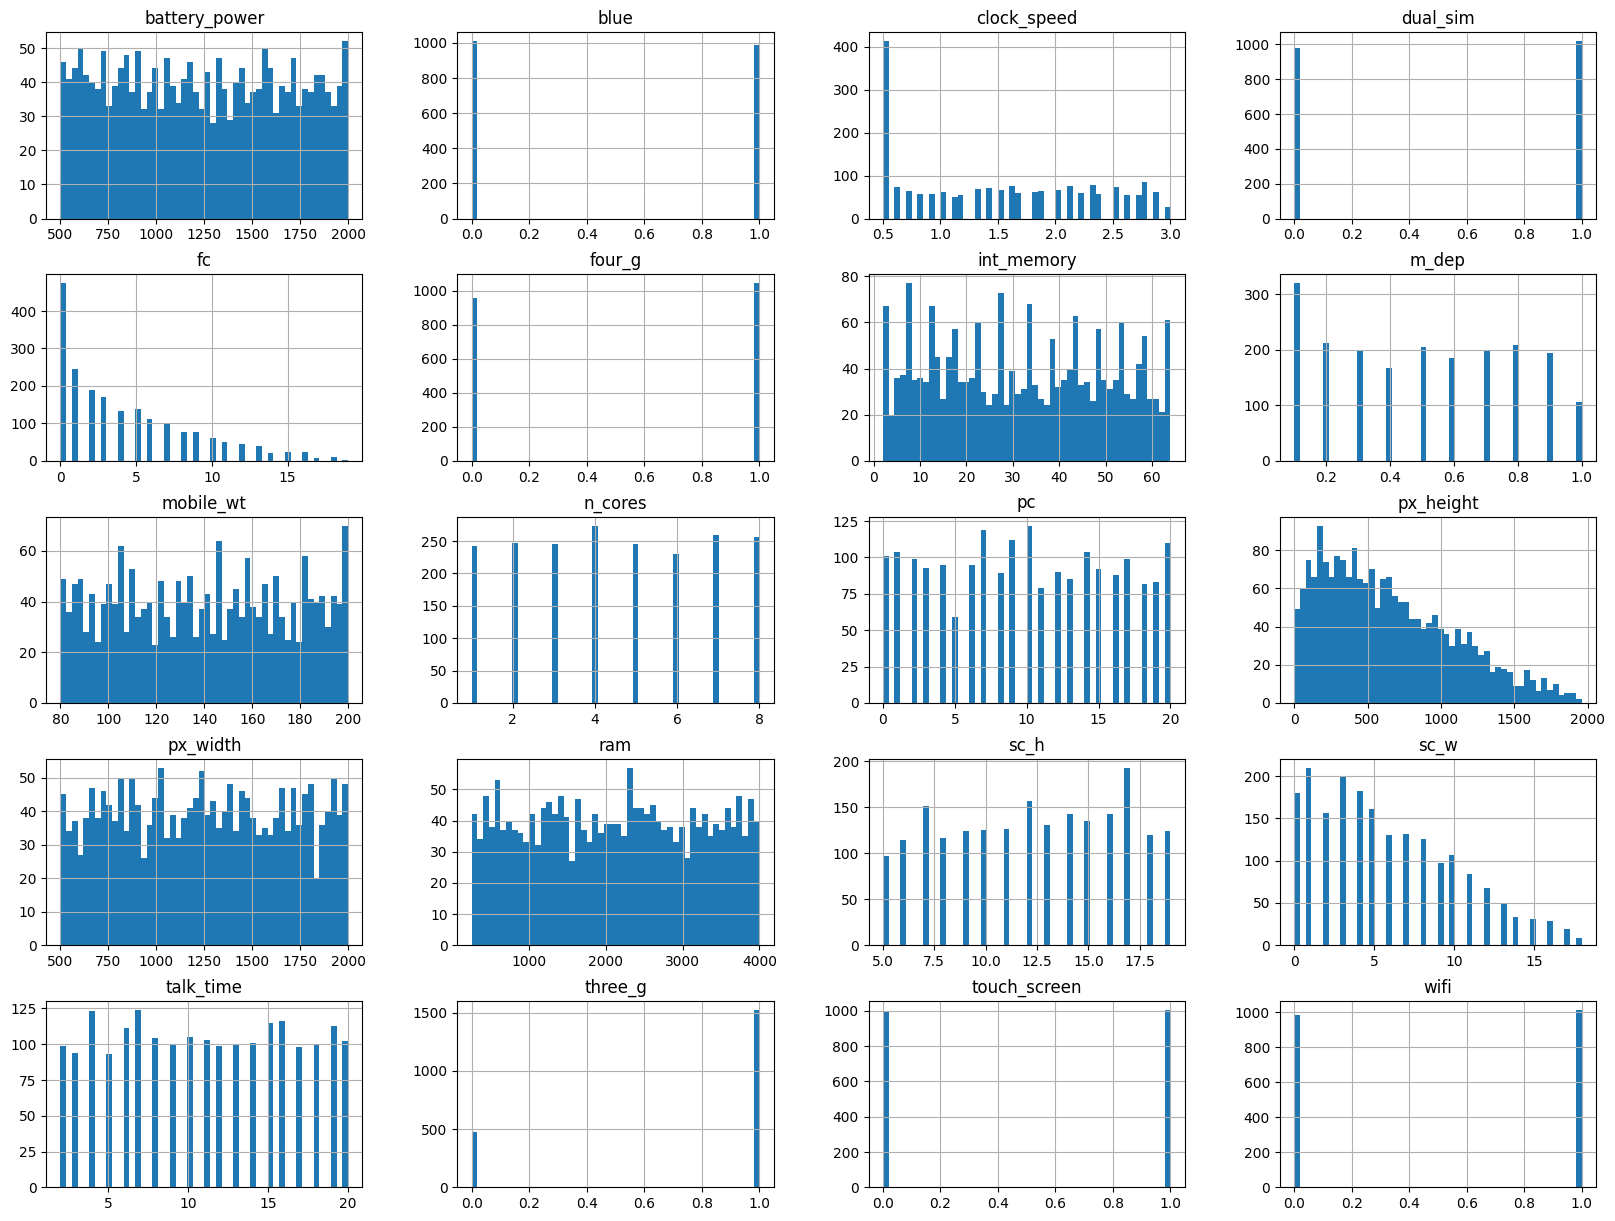

In [15]:
data.iloc[:,:-1].hist(bins = 50, figsize = (20, 15))
plt.show()

*Current columns*

In [16]:
data.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

### ***Feature Selection***

Drop all features with abs(correlation) with target_value - price_range less than 0.015

In [17]:
selected_features = ['battery_power','blue', 'dual_sim','fc','four_g','int_memory',
 'mobile_wt','pc','px_height','px_width','ram','sc_h','sc_w','talk_time',
 'three_g','touch_screen','wifi']
X_data, y_data = data[selected_features].to_numpy(), data['price_range'].to_numpy().reshape(-1,1)
print(X_data.shape, y_data.shape)

(2000, 17) (2000, 1)


*Data splitting*

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

*Custom Neural Net model*

In [26]:
class NeuralNet(BaseEstimator, ClassifierMixin):
    def __init__(self, n_classes, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 3000):
        self.n_classes = n_classes
        self.classes_ = np.array(range(n_classes))
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0

        self.is_cost_binary: bool
        if layer_activations[-1] == 'sigmoid':
            self.is_cost_binary = True
        else:
            self.is_cost_binary = False
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def transform(self, y_input):
        a_input = np.zeros((self.n_classes, y_input.shape[0]))
        for i in range(y_input.shape[0]):
            a_input[y_input[i][0]][i]=1
        return a_input.T

    def __softmax(self, Z):
        cache = Z
        A = np.exp(Z)/np.sum(np.exp(Z), axis=0, keepdims=True)
        return A, cache

    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __softmax_backward(self, dA, cache):
        Z = cache
        
        exp_z = np.exp(Z)
        softmax_Z = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        n = np.size(softmax_Z)
        tmp = np.tile(softmax_Z, n).reshape(n, n)
        dZ = np.dot(tmp * (np.identity(n) - np.transpose(tmp)), dA.reshape(-1))
        dZ = dZ.reshape(softmax_Z.shape)

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(self.__tanh(Z)[0], 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * (s * (1-s))

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ
    
    def __linear_forward(self, A, W, b):
        Z = np.matmul(W, A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))

        return Z, cache

    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}
        self.grads={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))
       
    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, parameters=None, keep_prob=1):
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost_binary(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def compute_cost_multi_class(self, A, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        res = Y * np.log(A + epsilon)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.matmul(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.matmul(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db
        
    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(dA, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db
    

    def __linear_activation_backward_last(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        dZ = dA
        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        L = len(caches)
        m = AL.shape[1]
        if self.is_cost_binary:
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
            current_cache = caches[L-1]
            self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])
        else:
            dAL = AL - Y
            current_cache = caches[L-1]
            self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward_last(dAL, Y, current_cache, activation = self.layer_activations[L - 1])



        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(self.grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            self.grads["dA" + str(l)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp
            self.grads["db" + str(l + 1)] = db_temp
    
    def __update_parameters(self):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * self.grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * self.grads["db" + str(l+1)]

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches
      
    def fit(self, X_vert, Y_vert, print_cost = False):
        
        X= X_vert.T
        Y = (self.transform(Y_vert)).T
        X_test = X_vert.T
        Y_test = (self.transform(Y_vert)).T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        if self.is_cost_binary:
            cost_function = self.compute_cost_binary
        else:
            cost_function = self.compute_cost_multi_class

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.parameters, self.keep_prob)

                cost_total += cost_function(AL, minibatch_Y)

                self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                #self.__gradient_check(self.parameters, self.grads, AL, minibatch_X, minibatch_Y, cost_function)

                self.__update_parameters()

            AL_test, _ = self.__forward_propagation(X_test, self.parameters, self.keep_prob)
            val_cost_total += cost_function(AL_test, Y_test)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            if self.epochs_without_improvement >= self.patience:
                if print_cost:
                    print(f"Early stopping after {i} epochs.")
                break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
     
    
    def predict_proba(self, X_vert, bool=True):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X, self.parameters)
        if self.layer_activations[-1] == 'sigmoid':
            if not bool:
                return np.column_stack((1 - probs.T, probs.T))
            result = np.column_stack((1 - probs.T, probs.T))[:, 1].T
        elif self.layer_activations[-1] == 'softmax':
            result = probs.T
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs, axis=1).reshape(-1, 1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result


In [20]:
def evaluate_classification(y_true, y_pred, labels = None):
    """
    Evaluate classification model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.
        labels (list): List of labels to index the matrix.

    Returns:
        accuracy (float): Accuracy score.
        report (pd.DataFrame): Classification report.
        confusion_matrix (pd.DataFrame): Confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), labels, labels)
    return accuracy, report, confusion

*Evaluate model on test data*

X_train: (1600, 17)
y_train: (1600, 1)
0-th iteration: 0.04414209387545795


C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\1658902193.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\1658902193.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))


Early stopping after 999 epochs.


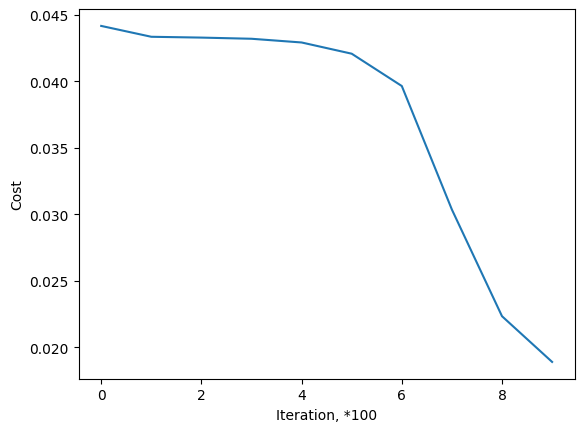

Accuracy: 
0.8975
Report: 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       105
           1       0.97      0.77      0.86        91
           2       0.97      0.78      0.87        92
           3       0.86      1.00      0.93       112

    accuracy                           0.90       400
   macro avg       0.91      0.89      0.89       400
weighted avg       0.91      0.90      0.89       400

Confusion: 
     0   1   2    3
0  105   0   0    0
1   19  70   2    0
2    0   2  72   18
3    0   0   0  112


In [21]:
alpha = 0.01
eps = 10**(-10)
num_iters = 10000

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))

layer_dims_1 = [X_train.shape[1], 20, 20, 20, 20, 20, 4]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid', 'relu', 'softmax']
batch_size_1 = 32
keep_prob_1 = 0.95
patience_1 = 1000

nn = NeuralNet(4, layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train, True)

y_test_pred = nn.predict(X_test)
accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")


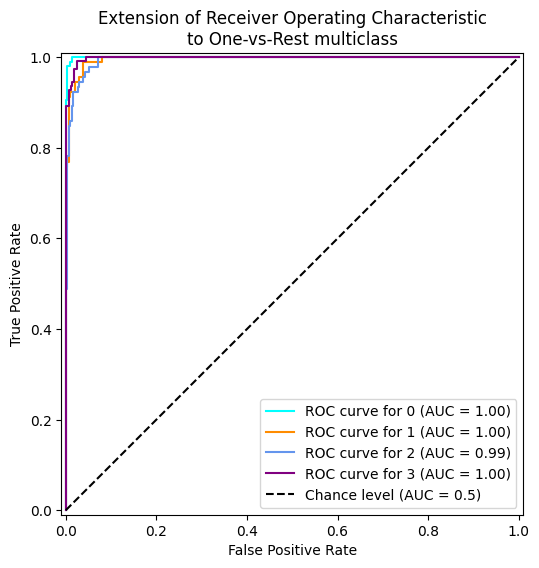

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "purple"])
y_score = nn.predict_proba(X_test)
y_onehot_test = nn.transform(y_test)

for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

*Brief check for train data*

In [23]:
y_train_pred = nn.predict(X_train)
accuracy, report, confusion = evaluate_classification(y_train, y_train_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

Accuracy: 
0.8825
Report: 
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       395
           1       0.96      0.80      0.87       409
           2       0.94      0.74      0.83       408
           3       0.81      1.00      0.89       388

    accuracy                           0.88      1600
   macro avg       0.89      0.88      0.88      1600
weighted avg       0.89      0.88      0.88      1600

Confusion: 
     0    1    2    3
0  395    0    0    0
1   63  327   19    0
2    0   12  303   93
3    0    0    1  387


*Check Grid Search*

In [27]:
CustomNN = NeuralNet(4, layer_dims_1, layer_activations_1, patience = 100)

params = {
    'mini_batch_size': [32, 64],
    'learning_rate': [0.01, 0.001],
    'keep_prob': [0.9, 0.95]
}

GridCustmobNN = GridSearchCV(CustomNN, params, cv=5, scoring='accuracy').fit(X_train, y_train)

grid_prediction = GridCustmobNN.predict(X_test)

best_params = GridCustmobNN.best_params_
grid_best_score= GridCustmobNN.best_score_

print("Best Parameters:", best_params)
print("Best on Train data:", grid_best_score)
print("Test data:", accuracy_score(y_test, grid_prediction))

C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - n

Best Parameters: {'keep_prob': 0.95, 'learning_rate': 0.01, 'mini_batch_size': 32}
Best on Train data: 0.8112499999999999
Test data: 0.8975


*Check Random Search*

In [28]:
CustomNNR = NeuralNet(4, layer_dims_1, layer_activations_1, patience = 100)

paramsR = {
    'mini_batch_size': [32, 64],
    'learning_rate': [0.01, 0.001],
    'keep_prob': [0.9, 0.95]
}

RandomCustomRegressor = RandomizedSearchCV(CustomNNR, paramsR, n_iter=10, cv=5, scoring='accuracy', random_state=42).fit(X_train, y_train)


random_prediction = RandomCustomRegressor.predict(X_test)

best_params = RandomCustomRegressor.best_params_
random_best_score = RandomCustomRegressor.best_score_

print("Best Parameters:", best_params)
print("Best on Train data:", random_best_score)
print("Test data:", accuracy_score(y_test, random_prediction))

c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: overflow encountered in exp
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipykernel_7316\877361938.py:46: RuntimeWarning: invalid value encountered in divide
  A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
C:\Users\Ректор\AppData\Local\Temp\ipyke

Best Parameters: {'mini_batch_size': 32, 'learning_rate': 0.01, 'keep_prob': 0.95}
Best on Train data: 0.8112499999999999
Test data: 0.8975


*SKlearn Logistic Regression model*

In [29]:
log_reg = LogisticRegression().fit(X_train, y_train)

test_predicted = log_reg.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, test_predicted)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 
0.645
Report: 
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       105
           1       0.52      0.56      0.54        91
           2       0.51      0.49      0.50        92
           3       0.70      0.75      0.72       112

    accuracy                           0.65       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.65      0.65      0.65       400

Confusion: 
    0   1   2   3
0  78  26   1   0
1  15  51  17   8
2   0  19  45  28
3   0   2  26  84


*SKlearn SVC model*

In [30]:
svc = SVC().fit(X_train, y_train)

test_predicted = svc.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, test_predicted)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

Accuracy: 
0.965
Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       105
           1       0.95      0.99      0.97        91
           2       0.94      0.95      0.94        92
           3       0.98      0.95      0.96       112

    accuracy                           0.96       400
   macro avg       0.96      0.97      0.96       400
weighted avg       0.97      0.96      0.97       400

Confusion: 
     0   1   2    3
0  103   2   0    0
1    1  90   0    0
2    0   3  87    2
3    0   0   6  106


c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*SKlearn MLP model*

In [31]:
mlp = MLPClassifier(hidden_layer_sizes=(20,50,20,50,20), activation='relu', batch_size=32, 
                    learning_rate='constant', learning_rate_init=0.001, max_iter=1000, n_iter_no_change=100).fit(X_train, y_train)

test_predicted = mlp.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, test_predicted)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 
0.915
Report: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.96       105
           1       0.89      0.90      0.90        91
           2       0.87      0.86      0.86        92
           3       0.90      0.97      0.94       112

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.92       400

Confusion: 
    0   1   2    3
0  96   9   0    0
1   0  82   9    0
2   0   1  79   12
3   0   0   3  109


c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### *Compare prediction on test data from custom model with mlp*

In [32]:
X_test_unknown = pd.read_csv('test.csv')[selected_features].to_numpy()

y_custom_predict = nn.predict(X_test_unknown)
y_mlp_predict = mlp.predict(X_test_unknown)
accuracy, report, confusion = evaluate_classification(y_mlp_predict, y_custom_predict)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

Accuracy: 
0.863
Report: 
              precision    recall  f1-score   support

           0       0.77      0.99      0.87       232
           1       0.82      0.69      0.75       221
           2       0.97      0.76      0.85       251
           3       0.90      0.98      0.94       296

    accuracy                           0.86      1000
   macro avg       0.87      0.85      0.85      1000
weighted avg       0.87      0.86      0.86      1000

Confusion: 
     0    1    2    3
0  229    3    0    0
1   67  153    1    0
2    0   30  190   31
3    0    0    5  291
